# 2D project DDW report

In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import math
import matplotlib.pyplot as plt
from cohortfunctions import *

In [2]:
# create new regression class with cohort solutions
class CohortLinearRegression():
    """
    Streamlined object using cohort functions
    """
    def __init__(self, df=None):
        self.df = df

    def fit(self, X=None, y=None):
        if X is None or y is None:
            print("Please add training data")
            return
        X = prepare_feature(X)
        y = prepare_target(y)
        iterations = 2500
        alpha = 0.01
        beta = np.zeros((X.shape[1],1))
        beta, J_storage = gradient_descent_linreg(X, y, beta, alpha, iterations)
        self.beta = beta
        self.J_storage = J_storage
        return self

    def predict(self, X):
        return predict_linreg(X, self.beta)

    @property
    def coef_(self):
        return self.beta[1:]
    @property
    def intercept_(self):
        return self.beta[0]

In [3]:
# reading the data
import os 
df = pd.read_excel("Datasets/2D dataset.xlsx")
df = df.drop(["Country Code", "temperature change per country in 2022", "ideal temperature?"], axis = 1)

In [4]:
df.head()

,Country,Agricultural Land( %),Co2-Emissions per ton,CPI,GDP,Population,Infant mortality,Minimum wage,Unemployment rate,Population: Labor force participation (%),temperature,Precipitation Depth (mm/year),Gini's index,GDP per capita,Human Development Index (2021),Prevalence of moderate or severe food insecurity in the total population (percent) (2022)
0,Afghanistan,0.581,8672.0,149.90,1.910135e+10,38041754.0,47.9,0.43,0.1112,0.489,NaN,327.0,NaN,502.115487,0.478,82.6
1,Albania,0.431,4536.0,119.05,1.527808e+10,2854191.0,7.8,1.12,0.1233,0.557,15.97,1485.0,29.4,5352.857411,0.796,33.1
2,Algeria,0.174,150006.0,151.36,1.699882e+11,43053054.0,20.1,0.95,0.1170,0.412,26.30,89.0,27.6,3948.343279,0.745,22.6
3,Andorra,0.400,469.0,NaN,3.154058e+09,77142.0,2.7,6.63,NaN,NaN,NaN,NaN,NaN,40886.391162,0.858,NaN
4,Angola,0.475,34693.0,261.73,9.463542e+10,31825295.0,51.6,0.71,0.0689,0.775,26.69,1010.0,51.3,2973.591160,0.586,79.9


In [5]:
# Imputation to give meaningful replacements for NaNs
print("Imputing...")
imp = IterativeImputer(max_iter=1000, random_state=0)
df_imp = imp.fit_transform(df.iloc[:,1:])
df_imp = pd.DataFrame(df_imp)
df_imp.columns = df.iloc[:,1:].columns
print(df_imp)
print("Imputed!")


Imputing...
     Agricultural Land( %)  Co2-Emissions per ton          CPI           GDP  \
0                    0.581                 8672.0   149.900000  1.910135e+10   
1                    0.431                 4536.0   119.050000  1.527808e+10   
2                    0.174               150006.0   151.360000  1.699882e+11   
3                    0.400                  469.0   182.314266  3.154058e+09   
4                    0.475                34693.0   261.730000  9.463542e+10   
..                     ...                    ...          ...           ...   
190                  0.245               164175.0  2740.270000  4.823593e+11   
191                  0.393               192668.0   163.520000  2.619212e+11   
192                  0.446                10609.0   157.580000  2.691440e+10   
193                  0.321                 5141.0   212.310000  2.306472e+10   
194                  0.419                10983.0   105.510000  2.144076e+10   

     Population  Infant mor

In [6]:
df_imp["Country"] = df.loc[:, ["Country"]]

df_country_name = df_imp["Country"]
df_without_country_name = df_imp.drop(["Country"], axis = 1)

In [7]:
df_without_country_name = pd.DataFrame(df_without_country_name)

In [8]:
# Normalization
meansVector = df_without_country_name.mean()
stdsVector = df_without_country_name.std()
df_without_country_name_norm = (df_without_country_name - df_without_country_name.mean()) / df_without_country_name.std()

In [9]:
targetDf = df_without_country_name_norm[["Prevalence of moderate or severe food insecurity in the total population (percent) (2022)"]]

In [10]:
featureDf = df_without_country_name_norm.drop(["Prevalence of moderate or severe food insecurity in the total population (percent) (2022)"], axis = 1)

In [11]:
xTrain, xTest, yTrain, yTest = split_data(featureDf, targetDf, random_state=100, test_size=0.2)

In [12]:
# Creating a base model with all predictors
model = CohortLinearRegression()
model.fit(xTrain, yTrain)
# model.score(xTrain, yTrain) score not implemented

In [13]:
# Testing the predictions
predictions = model.predict(xTest)
mean_squared_error(yTest, predictions)

0.2799890612420673

In [14]:
print(model.coef_)
print(model.intercept_)

[[-0.03383635]
 [-0.17980435]
 [-0.00129235]
 [ 0.18144634]
 [-0.41697073]
 [ 0.36816858]
 [ 0.04251128]
 [-0.04627187]
 [-0.00936706]
 [ 0.10459405]
 [-0.02406406]
 [ 0.19544574]
 [-0.13212382]
 [-0.28044762]]
[0.01040029]


In [15]:
predictions_1d = predictions.ravel()
yTest_1d = yTest.to_numpy().ravel()
pd.DataFrame({'preds': predictions_1d, 'actuals': yTest_1d})

,preds,actuals
0,-0.069889,-0.478803
1,-0.602421,-0.867076
2,1.639908,0.999909
3,-1.170310,-0.940245
4,-0.371255,-0.814397
5,-0.883206,-0.915775
6,-0.935204,-0.709524
7,-1.251328,-1.031135
8,0.848749,0.349538
9,-0.887835,-0.989186


In [16]:
basePredictors = pd.DataFrame({"predictors": xTrain.columns, "coefs": model.coef_.ravel()})
basePredictors["coefs_abs"] = basePredictors["coefs"].abs()
basePredictors = basePredictors.sort_values("coefs_abs", ascending = False)
basePredictors = basePredictors.drop(["coefs_abs"], axis = 1)
basePredictors

,predictors,coefs
4,Population,-0.416971
5,Infant mortality,0.368169
13,Human Development Index (2021),-0.280448
11,Gini's index,0.195446
3,GDP,0.181446
1,Co2-Emissions per ton,-0.179804
12,GDP per capita,-0.132124
9,temperature,0.104594
7,Unemployment rate,-0.046272
6,Minimum wage,0.042511


In [17]:
df_without_country_name_better = df_without_country_name.drop(["temperature", "Unemployment rate", "Minimum wage", "Agricultural Land( %)", "Precipitation Depth (mm/year)", "Population: Labor force participation (%)", "CPI", "GDP per capita"], axis = 1)
df_without_country_name_better
betterMeansVector = df_without_country_name_better.mean()
betterStdsVector = df_without_country_name_better.std()
df_without_country_name_better_norm = (df_without_country_name_better - df_without_country_name_better.mean()) / df_without_country_name_better.std()
betterTargetDf = df_without_country_name_better_norm[["Prevalence of moderate or severe food insecurity in the total population (percent) (2022)"]]
betterFeatureDf = df_without_country_name_better_norm.drop(["Prevalence of moderate or severe food insecurity in the total population (percent) (2022)"], axis = 1)
xTrain, xTest, yTrain, yTest = split_data(betterFeatureDf, betterTargetDf, random_state=42, test_size=0.3)

In [18]:
import itertools

def all_combinations(lst):
    # List to store all combinations
    comb_list = []

    # Generate combinations for all lengths
    for r in range(1, len(lst) + 1):
        comb_list.extend(itertools.combinations(lst, r))

    return comb_list

# Example usage
combinations = all_combinations(df_without_country_name_better.columns)
len(combinations)

127

In [19]:
# we have created two gridSearches one with the cohort LinearRegression Object, one with sklearn's LinearRegression object,
# we use the sklearn one for speed, but the cohort one should give the same result

def cohortgridSearch(xTrain, xTest, yTrain, yTest):
  allCombs = all_combinations(xTrain.columns)
  bestcomb = None
  bestModelCoefs = []
  bestError = 10000000
  i = 0
  print(len(allCombs))
  print(f"Combinations to check: {len(allCombs)}")
  for comb in allCombs:
    i += 1
    print(i)
    currXTrain = xTrain[list(comb)]
    currXTest = xTest[list(comb)]
    currModel = CohortLinearRegression()
    currModel.fit(currXTrain, yTrain)
    # model.score(xTrain, yTrain)
    predictions = currModel.predict(currXTest)
    currError = mean_squared_error(yTest, predictions)
    if currError < bestError:
      bestError = currError
      bestModelCoefs = currModel.coef_
      bestcomb = comb
      print(f"New lowest error: {bestError}\n Best new combination: {bestcomb}")

    # print(calculate_p_values(currModel, currXTrain, yTrain))
    # break
  return bestModelCoefs, bestError, bestcomb

In [20]:
from sklearn.linear_model import LinearRegression

def gridSearch(xTrain, xTest, yTrain, yTest):
  allCombs = all_combinations(xTrain.columns)
  bestModelCoefs = []
  bestcomb = None
  bestError = 10000000
  #i = 0
  print(len(allCombs))
  print(f"Combinations to check: {len(allCombs)}")
  for comb in allCombs:
    #i += 1
    #print(i)
    currXTrain = xTrain[list(comb)]
    currXTest = xTest[list(comb)]
    currModel = LinearRegression()
    currModel.fit(currXTrain, yTrain)
    # model.score(xTrain, yTrain)
    predictions = currModel.predict(currXTest)
    currError = mean_squared_error(yTest, predictions)
    if currError < bestError:
      bestError = currError
      bestModelCoefs = currModel.coef_
      bestcomb = comb
      print(f"New lowest error: {bestError}\n Best new combination: {bestcomb}")

    # print(calculate_p_values(currModel, currXTrain, yTrain))
    # break
  return bestModelCoefs, bestError, bestcomb

betterModelCoefs, betterError, bettercomb = gridSearch(xTrain, xTest, yTrain, yTest)

63
Combinations to check: 63
New lowest error: 0.7987791375840352
 Best new combination: ('Co2-Emissions per ton',)
New lowest error: 0.7715804351104342
 Best new combination: ('GDP',)
New lowest error: 0.16828204726265406
 Best new combination: ('Infant mortality',)
New lowest error: 0.10846248547924188
 Best new combination: ('Human Development Index (2021)',)
New lowest error: 0.10381977029804881
 Best new combination: ('Co2-Emissions per ton', 'Human Development Index (2021)')
New lowest error: 0.09165640012143364
 Best new combination: ('Population', 'Human Development Index (2021)')
New lowest error: 0.09019887899186664
 Best new combination: ('GDP', 'Population', 'Human Development Index (2021)')
New lowest error: 0.07840621844609305
 Best new combination: ('Population', 'Infant mortality', 'Human Development Index (2021)')
New lowest error: 0.07663277014965125
 Best new combination: ('GDP', 'Population', 'Infant mortality', 'Human Development Index (2021)')
New lowest error: 0.

In [21]:
betterModelCoefs

array([[ 0.01624751, -0.46949967,  0.42448423,  0.22497711, -0.31820982]])

In [22]:
betterPredictors = pd.DataFrame({"predictors": bettercomb, "coefs": betterModelCoefs[0]})
betterPredictors["coefs_abs"] = betterPredictors["coefs"].abs()
betterPredictors = betterPredictors.sort_values("coefs_abs", ascending = False)
betterPredictors = betterPredictors.drop(["coefs_abs"], axis = 1)
betterPredictors

,predictors,coefs
1,Population,-0.469500
2,Infant mortality,0.424484
4,Human Development Index (2021),-0.318210
3,Gini's index,0.224977
0,GDP,0.016248


In [69]:
# function to display charts
def chart_display(df, predictors, xtest, ytest, ypred):
    for i in range(predictors.shape[0]):
        x_axis = df.loc[:,predictors].columns[i]
        #print(f"{i+1}: Food Insecurity vs {x_axis} (Lower is better)")
        fig,ax = plt.subplots()
        plt.scatter(xtest[x_axis], ytest)
        plt.scatter(xtest[x_axis], ypred)
        ax.set_title(f"Food Insecurity vs {x_axis} (Lower is better)")
        ax.set_xlabel(x_axis)
        ax.set_ylabel("Food Insecurity Index")
        plt.show()
        fig.clear()
        ax.clear()

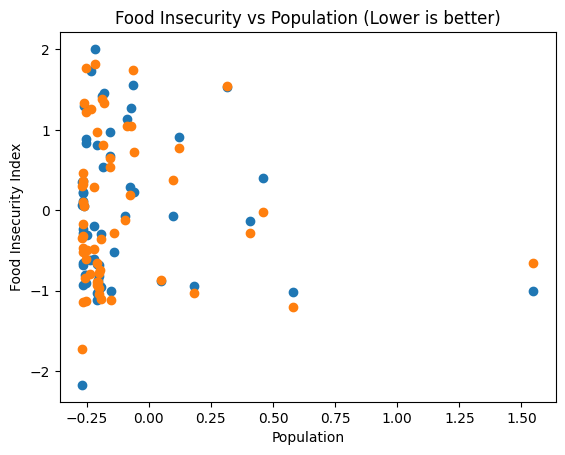

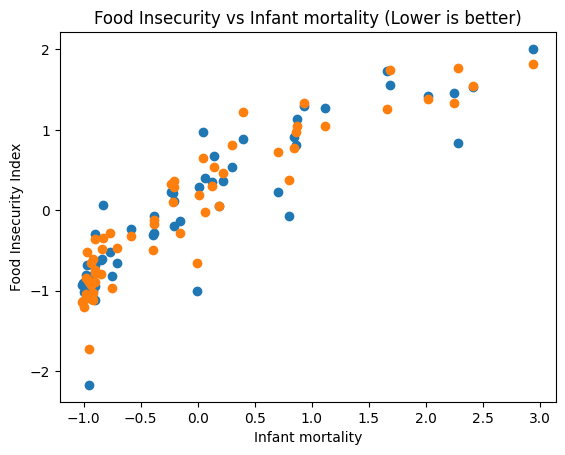

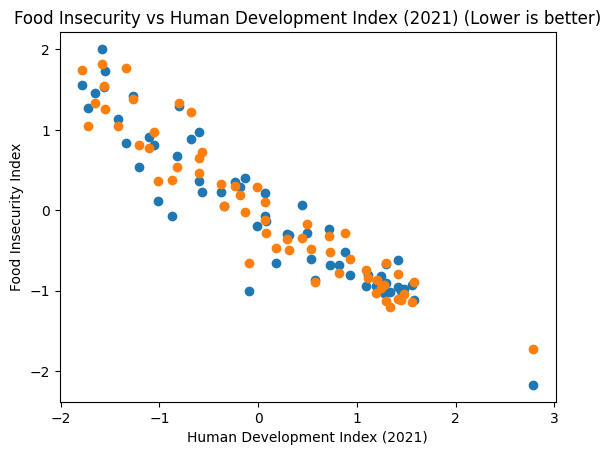

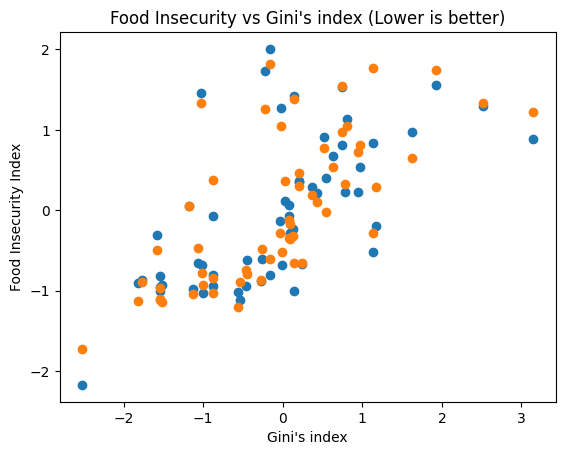

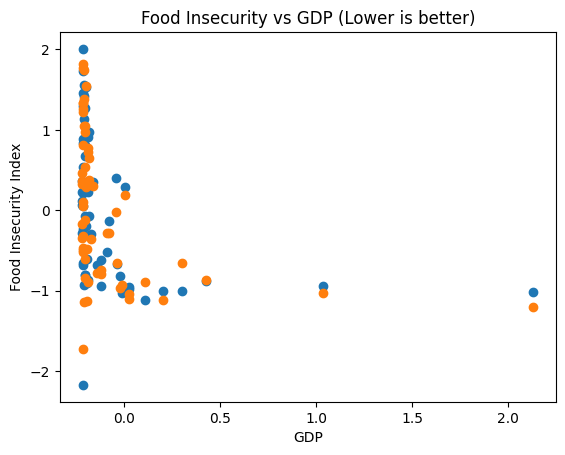

In [70]:
xrain, xest, yrain, yest = split_data(betterFeatureDf[betterPredictors['predictors']], betterTargetDf, random_state=42, test_size=0.3)
better_model = LinearRegression()
better_model.fit(xrain, yrain)
redictions = better_model.predict(xest)
chart_display(betterFeatureDf, betterPredictors.loc[:,'predictors'], xest, yest, redictions)

In [25]:
# Again two gridsearchs, but now using cross validation for better verification

from sklearn.model_selection import cross_validate

def cohortgridSearch_cv(entireX, entireY):
  allCombs = all_combinations(xTrain.columns)
  bestModelCoefs = []
  bestcomb = None
  bestError = 10000000
  # i = 0
  print(len(allCombs))
  print(f"Combinations to check: {len(allCombs)}")
  for comb in allCombs:
    # i += 1
    # print(i)
    currEntireX = entireX[list(comb)]
    currModel = CohortLinearRegression()
    currModel.fit(currEntireX, entireY)
    # model.score(xTrain, yTrain)
    # predictions = currModel.predict(currXTest)
    # currError = mean_squared_error(yTest, predictions)
    currCrossVal = cross_validate(currModel, currEntireX, entireY, cv=10, scoring="neg_mean_squared_error", return_train_score = True)
    currMeanError = - sum(currCrossVal["test_score"]) / len(currCrossVal["test_score"])
    if currMeanError < bestError:
      bestError = currMeanError
      bestModelCoefs = currModel.coef_
      bestcomb = comb
      print(f"New lowest error: {bestError}\n Best new combination: {bestcomb}")

    # print(calculate_p_values(currModel, currXTrain, yTrain))
    # break
  return bestModelCoefs, bestError, bestcomb

''' deprecated code
def gridSearch_withcv(xTrain, xTest, yTrain, yTest, entireX, entireY):
  allCombs = all_combinations(xTrain.columns)
  bestModelCoefs = []
  bestError = 10000000
  # i = 0
  print(len(allCombs))
  for comb in allCombs:
    # i += 1
    # print(i)
    currEntireX = entireX[list(comb)]
    currXTrain = xTrain[list(comb)]
    currXTest = xTest[list(comb)]
    currModel = LinearRegression()
    currModel.fit(currXTrain, yTrain)
    # model.score(xTrain, yTrain)
    # predictions = currModel.predict(currXTest)
    # currError = mean_squared_error(yTest, predictions)
    currCrossVal = cross_validate(currModel, currEntireX, entireY, cv=10, scoring="neg_mean_squared_error", return_train_score = True)
    currMeanError = - sum(currCrossVal["test_score"]) / len(currCrossVal["test_score"])
    if currMeanError < bestError:
      print(currMeanError)
      bestError = currMeanError
      bestModelCoefs = currModel.coef_

    # print(calculate_p_values(currModel, currXTrain, yTrain))
    # break
  return bestModelCoefs, bestError
'''

def gridSearch_cv(entireX, entireY):
  allCombs = all_combinations(xTrain.columns)
  bestModelCoefs = []
  bestcomb = None
  bestError = 10000000
  # i = 0
  print(f"Combinations to check: {len(allCombs)}")
  for comb in allCombs:
    # i += 1
    # print(i)
    currEntireX = entireX[list(comb)]
    currModel = LinearRegression()
    currModel.fit(currEntireX, entireY)
    # model.score(xTrain, yTrain)
    # predictions = currModel.predict(currXTest)
    # currError = mean_squared_error(yTest, predictions)
    currCrossVal = cross_validate(currModel, currEntireX, entireY, cv=10, scoring="neg_mean_squared_error", return_train_score = True)
    currMeanError = - sum(currCrossVal["test_score"]) / len(currCrossVal["test_score"])
    if currMeanError < bestError:
      bestError = currMeanError
      bestModelCoefs = currModel.coef_
      bestcomb = comb
      print(f"New lowest error: {bestError}\n Best new combination: {bestcomb}")

    # print(calculate_p_values(currModel, currXTrain, yTrain))
    # break
  return bestModelCoefs, bestError, bestcomb

In [26]:
# finding best model from the subset of 6 human selected predictors based upon our initial model
cvModelCoefs, cvError, cvcomb = gridSearch_cv(betterFeatureDf, betterTargetDf)

Combinations to check: 63
New lowest error: 0.7983618576205744
 Best new combination: ('Co2-Emissions per ton',)
New lowest error: 0.4008719821847267
 Best new combination: ('Infant mortality',)
New lowest error: 0.39047555259567385
 Best new combination: ('Human Development Index (2021)',)
New lowest error: 0.2793046539036386
 Best new combination: ('Co2-Emissions per ton', 'Infant mortality')
New lowest error: 0.2021968787040474
 Best new combination: ('Population', 'Infant mortality')
New lowest error: 0.1900562826361981
 Best new combination: ('Population', 'Human Development Index (2021)')
New lowest error: 0.1505439114112121
 Best new combination: ('Population', 'Infant mortality', "Gini's index")
New lowest error: 0.12838714443932506
 Best new combination: ('Population', 'Infant mortality', "Gini's index", 'Human Development Index (2021)')
New lowest error: 0.1269925536123704
 Best new combination: ('Co2-Emissions per ton', 'GDP', 'Population', 'Infant mortality', "Gini's index"

In [27]:
cvPredictors = pd.DataFrame({"predictors": cvcomb, "coefs": cvModelCoefs[0]})
cvPredictors["coefs_abs"] = cvPredictors["coefs"].abs()
cvPredictors = cvPredictors.sort_values("coefs_abs", ascending = False)
cvPredictors = cvPredictors.drop(["coefs_abs"], axis = 1)
cvPredictors

,predictors,coefs
3,Infant mortality,0.380742
2,Population,-0.371355
5,Human Development Index (2021),-0.363874
0,Co2-Emissions per ton,-0.270837
1,GDP,0.208718
4,Gini's index,0.203102


# Testing ALLLLLLLL Combinations

In [28]:
alldf_without_country_name_better = df_without_country_name.drop(['GDP per capita'], axis=1)

In [30]:
allMeansVector = df_without_country_name_better.mean()
allStdsVector = df_without_country_name_better.std()
alldf_without_country_name_better_norm = (alldf_without_country_name_better - alldf_without_country_name_better.mean()) / alldf_without_country_name_better.std()
allTargetDf = alldf_without_country_name_better_norm[["Prevalence of moderate or severe food insecurity in the total population (percent) (2022)"]]
allFeatureDf = alldf_without_country_name_better_norm.drop(["Prevalence of moderate or severe food insecurity in the total population (percent) (2022)"], axis = 1)
xTrain, xTest, yTrain, yTest = split_data(allFeatureDf, allTargetDf, random_state=42, test_size=0.3)

In [31]:
# finding best Model from all subsets of model predictors using cross validation
bestModelCoefs, bestError, best_possible_comb = gridSearch_cv(allFeatureDf, allTargetDf)

Combinations to check: 8191
New lowest error: 0.9827777199688402
 Best new combination: ('Agricultural Land( %)',)
New lowest error: 0.7983618576205744
 Best new combination: ('Co2-Emissions per ton',)
New lowest error: 0.4008719821847267
 Best new combination: ('Infant mortality',)
New lowest error: 0.39047555259567385
 Best new combination: ('Human Development Index (2021)',)
New lowest error: 0.38850829255194014
 Best new combination: ('Agricultural Land( %)', 'Human Development Index (2021)')
New lowest error: 0.2793046539036386
 Best new combination: ('Co2-Emissions per ton', 'Infant mortality')
New lowest error: 0.2021968787040474
 Best new combination: ('Population', 'Infant mortality')
New lowest error: 0.1900562826361981
 Best new combination: ('Population', 'Human Development Index (2021)')
New lowest error: 0.17787168078998378
 Best new combination: ('Population', 'Infant mortality', 'Minimum wage')
New lowest error: 0.17068217493613227
 Best new combination: ('Population', 

In [32]:
bestPredictors = pd.DataFrame({"predictors": best_possible_comb, "coefs": bestModelCoefs[0]})
bestPredictors["coefs_abs"] = bestPredictors["coefs"].abs()
bestPredictors = bestPredictors.sort_values("coefs_abs", ascending = False)
bestPredictors = bestPredictors.drop(["coefs_abs"], axis = 1)
bestPredictors

,predictors,coefs
0,Population,-0.443046
1,Infant mortality,0.392380
4,Human Development Index (2021),-0.290676
3,Gini's index,0.176507
2,temperature,0.111737


In [33]:
# best mean squared error
bestError

0.12200982549752781

In [36]:
# a test with the best
xain, xst, yain, yst = split_data(allFeatureDf[bestPredictors['predictors']], allTargetDf, random_state=42, test_size=0.3)
best_model = LinearRegression()
best_model.fit(xain, yain)
rdictions = best_model.predict(xst)

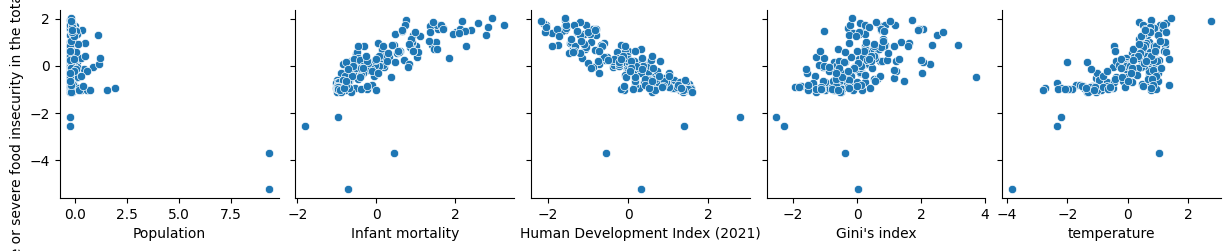

In [41]:
# showing the relationship between the best predictors and our target
plot0 = sns.pairplot(data=alldf_without_country_name_better_norm,
                    y_vars = ['Prevalence of moderate or severe food insecurity in the total population (percent) (2022)'],
                    x_vars = bestPredictors['predictors']) 

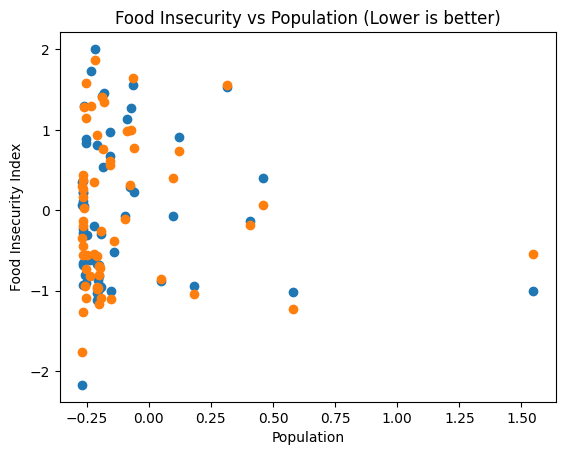

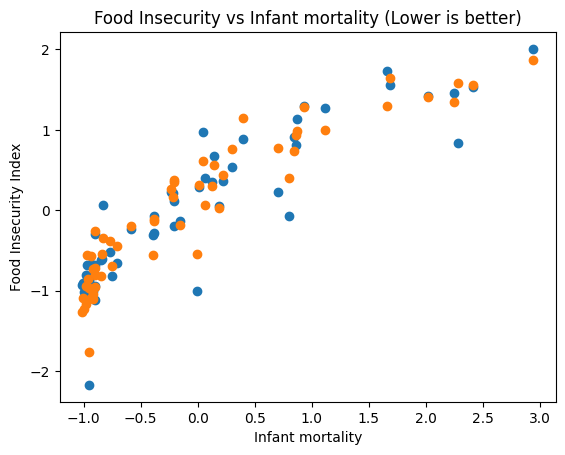

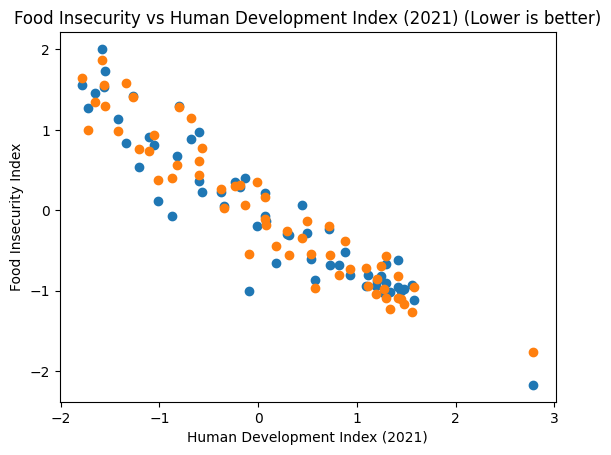

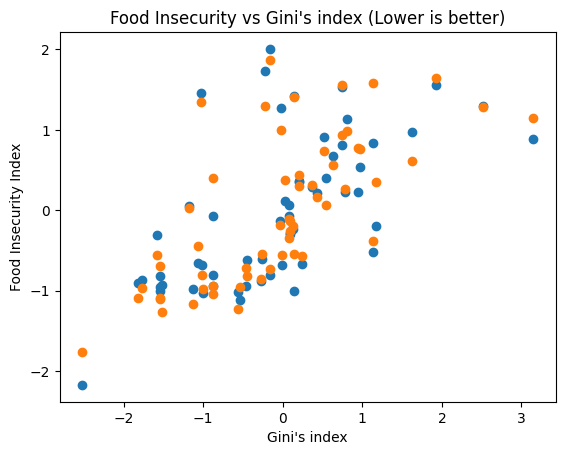

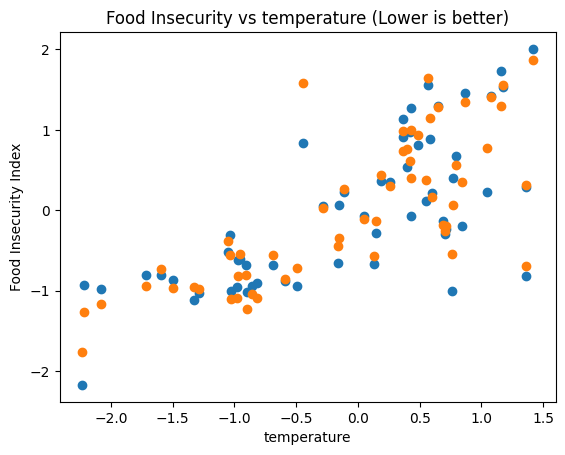

In [71]:
# showing the test vs train values for each predictor
chart_display(allFeatureDf, bestPredictors.loc[:,'predictors'], xst, yst, rdictions)

In [44]:
kenya = df_without_country_name_better_norm.iloc[[88]]
kenya

,Agricultural Land( %),Co2-Emissions per ton,CPI,GDP,Population,Infant mortality,Minimum wage,Unemployment rate,Population: Labor force participation (%),temperature,Precipitation Depth (mm/year),Gini's index,Human Development Index (2021),Prevalence of moderate or severe food insecurity in the total population (percent) (2022)
88,0.440442,-0.186242,-0.02542,-0.175804,0.085584,0.482986,-0.6871,-0.805373,1.139785,0.519776,-0.702173,0.259592,-0.939804,1.363469


In [45]:
kenya = kenya.loc[:, bestPredictors.loc[:,'predictors']]
kenya

,Population,Infant mortality,Human Development Index (2021),Gini's index,temperature
88,0.085584,0.482986,-0.939804,0.259592,0.519776


In [46]:
best_model.feature_names_in_

array(['Population', 'Infant mortality', 'Human Development Index (2021)',
       "Gini's index", 'temperature'], dtype=object)

In [47]:
kenyaPred = best_model.predict(kenya)


In [48]:
kenyaMean = df["Prevalence of moderate or severe food insecurity in the total population (percent) (2022)"].mean()

In [49]:
kenyaStd = df["Prevalence of moderate or severe food insecurity in the total population (percent) (2022)"].std()

In [50]:
kenyaPred * kenyaStd + kenyaMean

array([[49.64189374]])

In [51]:
df.iloc[[88]].T

,88
Country,Kenya
Agricultural Land( %),0.485
Co2-Emissions per ton,17910.0
CPI,180.51
GDP,95503088538.0
Population,52573973.0
Infant mortality,30.6
Minimum wage,0.25
Unemployment rate,0.0264
Population: Labor force participation (%),0.747
